In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
import os
import sys

colab = True
if os.getenv("COLAB_RELEASE_TAG"):
    colab = True
else:
    colab = False

if colab:
    module_path = os.path.abspath(os.path.join('./real-hdd-failure/code/'))
    if module_path not in sys.path:
        sys.path.append(module_path)

    helper_path = os.path.abspath(os.path.join('./real-hdd-failure/code/helper/'))
    if helper_path not in sys.path:
        sys.path.append(helper_path)
    !{sys.executable} -m pip install -r ./real-hdd-failure/requirements.txt
else:
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

    helper_path = os.path.abspath(os.path.join('../helper'))
    if helper_path not in sys.path:
        sys.path.append(helper_path)
# !{sys.executable} -m pip install -r ../../requirements.txt

In [4]:
from helper.dataclass import HDDDataset
from helper.algorithms.Blending import Blending
from helper.algorithms.Stacking import Stacking
from helper.preprocessing import *
from helper.metrics import *
from helper.eda import *
from sklearn.model_selection import train_test_split
from helper.metrics import *
from helper.saver import Saver

## Data preprocessing

In [5]:
hdd_dataset = HDDDataset.read_csv('ST14000NM001G.csv')

In [6]:
preprocessor = Preprocessing(hdd_dataset)
preprocessor.clear_unused_data()
preprocessor.add_target_column()
preprocessor.prepare_train_df()
preprocessor.add_time_features()
preprocessor.train_test_val_split(train_size=0.75, val_size=0.15, test_size=0.1, sampling_strat=0.055, oversampling='Default')
preprocessor.normalize_data(method='formulae', inplace=True)
# preprocessor.normalize_data(method='YJ', inplace=True)
preprocessor.drop_unimportant_features(drop=13)
preprocessor.rescale_types()

Clearing unused columns...
Adding target column...
Prepairing train dataset...
Adding time features to unsplitted dataset...
Splitting train dataset...
Overampling with SMOTE


c:\Users\rocke\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Normalizing splitted dataset with formulae...
    Удаляем не нужные признаки...     
failure 
diff_smart_5_raw_1 
diff_smart_242_raw_1 
diff_smart_240_raw_1 
diff_smart_199_raw_1 
diff_smart_9_raw_1 
diff_smart_241_raw_1 
shift_smart_9_raw_1 
shift_smart_242_raw_1 
shift_smart_241_raw_1 
shift_smart_240_raw_1 
smart_241_raw 
smart_9_raw 


## Training

In [7]:
model = Blending()
preds = model.fit_predict(preprocessor.X_train, preprocessor.y_train, preprocessor.X_val, preprocessor.y_val, preprocessor.X_test)

=== Обучаем RandomForestClassifier...  ===
=== Обучаем CatBoostClassifier...  ===
=== Обучаем XGBClassifier...  ===
=== Обучаем мета модель... ===


## Testing

In [8]:
metrics = Metrics.get_metrics(preds, preprocessor.y_test)
print(metrics)
# Посмотрим метрики

{'accuracy': 0.9997438577078338, 'precision': 0.8786127167630058, 'recall': 0.7378640776699029, 'f1': 0.8021108179419525, 'auc_roc': 0.8688961536674874}


In [12]:
from sklearn.metrics import classification_report
print(classification_report(preprocessor.y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    292600
           1       0.88      0.74      0.80       206

    accuracy                           1.00    292806
   macro avg       0.94      0.87      0.90    292806
weighted avg       1.00      1.00      1.00    292806



## Logging

In [9]:
Saver.save(model, preprocessor, metrics, save_csv=False)

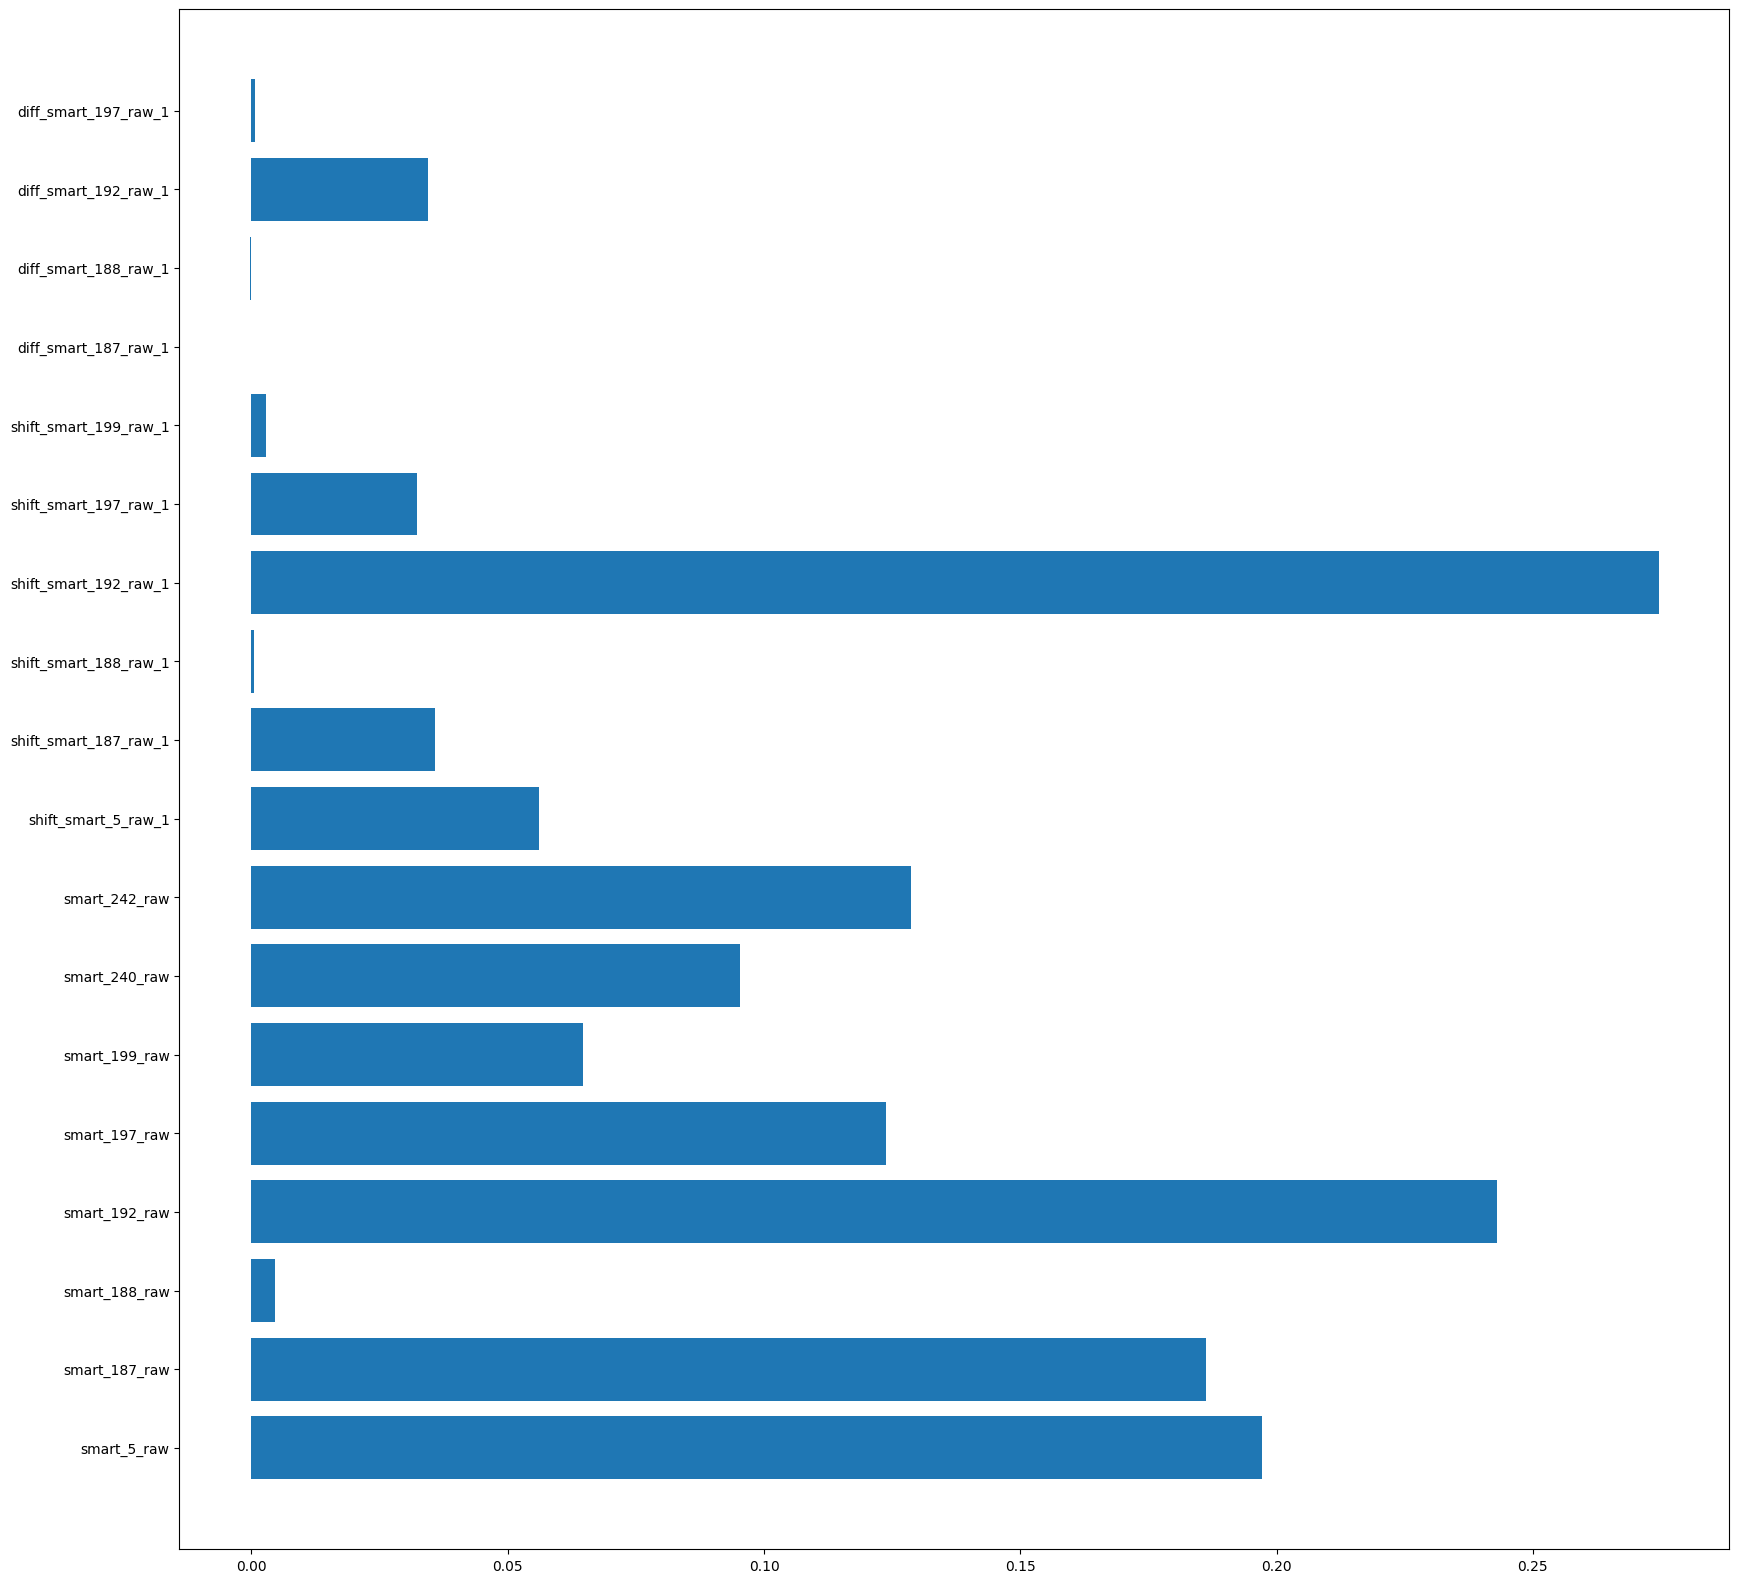

In [10]:
from sklearn.inspection import permutation_importance

# Перестановочная важность признаков
perm_importance = permutation_importance(model.models[2], preprocessor.X_test, preprocessor.y_test, scoring='f1')
importances = perm_importance.importances_mean
plt.figure(figsize=(20, 20))
plt.barh(preprocessor.X_test.columns, importances)
plt.show()